# GEOL 593: Seismology and Earth Structure

## Lab assignment 6: Measuring the Earth's Free Oscillations

In today's Lab we are going to explore how seismologists measure the Eath's free oscillations, aka normal modes. The normal modes of Earth are excited following large earthquakes, and can be thought of as the Earth "ringing like a bell". Each normal mode has a distinct pattern of displacement (called an "eigenfunction") and frequency (called an "eigenfrequency"). By measuring the ground displacement spectrum recorded at a seismic station following a large earthquake, we can recover the normal mode frequencies. Mode frequencies are sensitive to the interior structure of the entire planet, making measurements at even a single seismic station valuable for understanding the Earth's average seismic velocity and density.

To do this analysis, we will use seismic data recorded from the 2004 Mw 9.1 Sumatra earthquake, which is one of the largest and deadliest earthquakes on record (in large part due to damage caused by the ensuing tsunami). For more information on the technical details of the 2004 Sumatra event (including the moment tensor solution), see here: https://earthquake.usgs.gov/earthquakes/eventpage/official20041226005853450_30/executive



In [48]:
#Imports
import cartopy
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.geodetics import gps2dist_azimuth #helper function for calculating distances and angles between points
from obspy.geodetics import kilometer2degrees #helper function for converting between kilometers and degrees on Earth
from obspy.geodetics import degrees2kilometers
%matplotlib inline

### Downloading and plotting seismic data

Let's start by downloading data from the Global Seismographic Network (station codes = 'IU'). We will examine only vertical component data. Also, note that we are using the "LH?" channel, which stands for "Long-Period" and "High-Gain". The LH channels are sampled at a relatively low sampling rate (1 Hz), so downloading data shouldn't take too long (several minutes to download hours of data for the entire network, assuming a reasonably fast internet connection). 

Run the code below to download data from the IU network for 12 hours following the Sumatra event. 

In [49]:
client = Client("IRIS")
origin = UTCDateTime('2004-12-26 00:58:52') #origin time of Sumatra event
ndays = 0.5 # we want 12 hours of seismic data
starttime = origin
endtime = starttime + 60.*60.*24. * ndays 

st = client.get_waveforms(network="IU",station="*",location="00",channel="LHZ",starttime=starttime,endtime=endtime,attach_response=True) #download waveforms
inv = client.get_stations(network='IU',starttime=starttime,endtime=endtime) #download station data to an 'inventory'
st.detrend('linear') #remove linear trend
st.detrend('demean') #remove average
st.remove_response(output='DISP',water_level=10.0,pre_filt = [0.0001, 0.0005, 45, 50]) #correct for instrument response

print(st)

66 Trace(s) in Stream:

IU.ADK.00.LHZ | 2004-12-26T00:58:52.784634Z - 2004-12-26T02:21:18.784634Z | 1.0 Hz, 4947 samples
...
(64 other traces)
...
IU.YSS.00.LHZ | 2004-12-26T00:58:52.785646Z - 2004-12-26T12:58:51.785646Z | 1.0 Hz, 43200 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


Next, we will plot all of the seismic waveform data as a record section. The function `plot_record_section` is provided below to do this. It should look familiar, because it is a modified version of a function that you used in a previous lab.

In [50]:
def plot_record_section(st,inv,eq_longitude=evlo,eq_latitude=evla,n_hours=12,scale_factor=5, Tmin=200, Tmax=500):
    '''
    inputs----------------------------------------
    
    st: obspy stream containing data to be plotted (downloaded w/ client.get_waveforms)
    inv: obspy inventory object containing station metadata (downloaded w/ client.get_stations)
    eq_longitude: longitude of earthquake (defaults to 'evlo', which is defined above)
    eq_latitude: latitude of earthquake (defaults to 'evla', which is defined above)
    scale_factor: scale factor for waveforms (defaults to 5, larger values will amplify seismograms more)
    '''
    fig = plt.figure(figsize=[7,9])
    
    #bandpass filter the stream-------------------------------------
    freqmin = 1./Tmax
    freqmax = 1./Tmin
    stc = st.copy() #copy the stream
    stc.taper(0.03)     #taper (should always do before applying a filter)
    stc.filter('bandpass',freqmin=freqmin,freqmax=freqmax,corners=2,zerophase=True)
    
    #loop through and plot each trace. First, we must find the epicentral distance!
    for tr in stc:
        station = inv.select(station=tr.stats.station)[0][0]
        dist_m,az,baz = gps2dist_azimuth(eq_latitude,eq_longitude,station.latitude,station.longitude)
        dist_km = dist_m/1000.
        dist_deg = kilometer2degrees(dist_km)
        
        #scale the data before plotting
        tr.normalize() # normalize the trace so the maximum value is 1
        tr.data *= scale_factor #scale the data so the maximum value is 'scale_factor'
        
        time = tr.times()
        time_hr = time/(60.*60)
        plt.plot(tr.data+dist_deg,time_hr,color='k',alpha=0.5,linewidth=0.5)
        
    plt.xlim([0,180])
    plt.ylim([0,n_hours])
    plt.xlabel('distance (degrees)')
    plt.ylabel('time (hrs)')
    plt.show()

###  <font color='red'>Question 1 </font> 

a) Make a record section of your data by calling the `plot_record_section` function. Note, the function requires you to provide the longitude and latitude of the earthquake. The lon/lat of the Sumatra event are 95.9 and 3.41, respectively.

b) Describe the record section. What are the dominant waves that you observe, and how can you tell? 

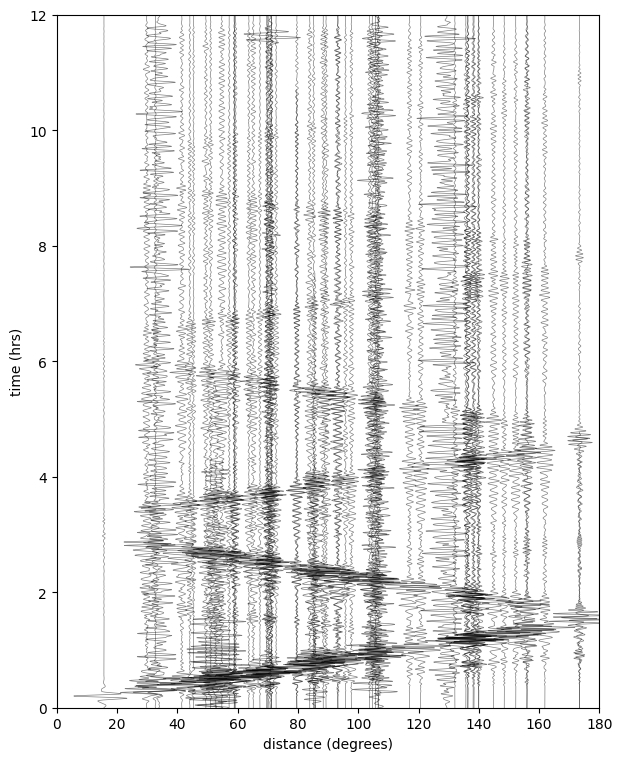

In [51]:
#Answer Q1 here.

### Measuring mode frequencies

Now we will explore how to measure normal mode frequencies. Rather than measure mode frequencies for every station in the network, we will focus on using just one station. The station we will use is "ANMO", which is one of the stations in the IU network and is located in an underground vault at the USGS Albuquerque Seismological Laboratory. 

###  <font color='red'>Question 2 </font> 

Modify the code block you used above to download 4 days of seismic data from ANMO. Be sure to follow the same processing steps as before (e.g., remove instrument response to displacement, etc.). Plot the data with `st.plot()`

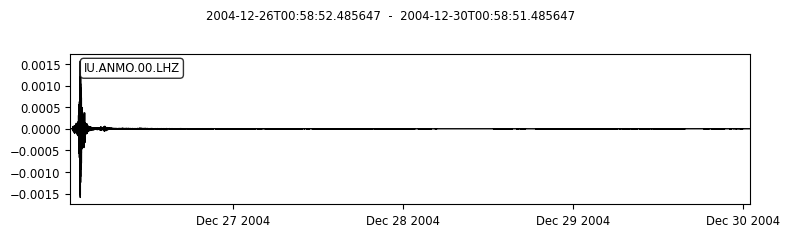

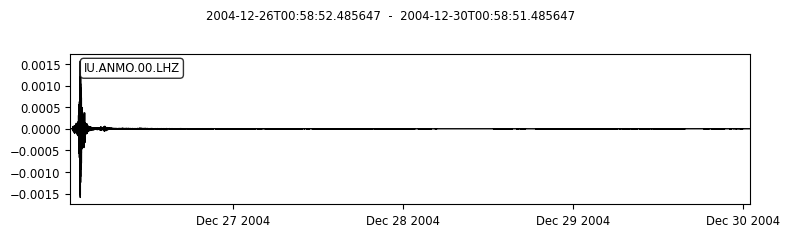

In [52]:
#Answer Q2 here.

To calculate the amplitude spectrum, we will use the function `scipy.signal.welch` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html), which relies on the Fast Fourier Transform (FFT). This function estimates the spectrum by dividing the signal into multiple overlapping segments and averaging the spectrum in each segment. The frequency resolution is controlled by two parameters: i) `nfft`, which describes the number of points to use in the FFT, and ii) `nperseg`, which is the number of points in each segment. Here the default values are set to $\mathrm{nfft} = 2^{20}$ and $\mathrm{nperseg} = 2^{18}$, although you may want to change these depending on the number of points in your seismogram. 

To simply things, the function `plot_mode_spectra` is provided below, which calls `scipy.signal.welch` and plots the resulting spectrum. The function takes an obspy stream object (should contain only one trace), the minimum and maximum frequency range to plot, in mHz (`freq_min_mhz`, `freq_max_mhz`), and the parameters controlling the frequency resolution of `scipy.signal.welch`.


In [53]:
from scipy.signal import welch

def plot_mode_spectra(st,freq_min_mhz,freq_max_mhz,nfft=2**20,nperseg=2**18):
    '''
    function that takes fft of data in stream and plots spectra in given frequency range
    '''
    
    tr = st.copy()[0]
    samprate = tr.stats.sampling_rate
    data = tr.data
    f,Pxx = welch(data,fs=1.0,nfft=nfft,nperseg=nperseg,scaling='spectrum')
    
    amp = np.sqrt(Pxx)
    f_mhz = f*1000.
    
    inds = np.where((f_mhz >= freq_min_mhz) & (f_mhz <= freq_max_mhz))
    fig,ax = plt.subplots(figsize=[9,3])
    ax.plot(f_mhz[inds], amp[inds])
    ax.margins(0) #no padding on sides
    ax.set_xlabel('freq (mHz)')
    ax.set_ylabel('amplitude')
    plt.show()

###  <font color='red'>Question 3 </font> 

Use `plot_mode_spectra` to plot the amplitude spectrum of your obspy stream containing 4 days of LHZ component data from station IU.ANMO. Plot the spectrum between 0.2 and 1.5 mHz.

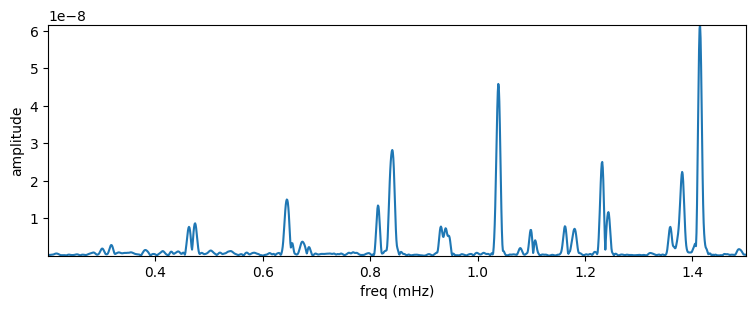

In [54]:
#Answer Question 3 here.

### Identifying modes in the spectra

The file `prem_mode_frequencies.csv` contains predicted mode frequencies of the fundamental mode and the first several overtones, calculated between frequencies of 0.2 - 1.5 mHz using the PREM model (Dziewonski & Anderson, 1981). The first column gives the name of the mode in the format $_nS_l$, where $n$ is the radial order (i.e., $n = 0$ corresponds to the fundamental mode), and $l$ is the degree (i.e., angular order). The second column is frequency in **mHz**. You can read this file in using pandas (e.g., `df = pandas.read_csv('prem_mode_frequencies.csv')`). The mode frequencies in this file can be used as a guide to identify the peaks in the calculated mode spectra. 

###  <font color='red'>Question 4 </font> 

What are the names of the 3 largest peaks in the spectrum? What do they have in common (e.g., are they all part of the same mode branch?, and if so speculate as to why). 

Hint: To double check that you have correctly identified a mode, you can plot the predicted mode frequency as a vertical line in your mode spectra plot using `plt.axvline()` (or `ax.axvline()` if you have created an axis object).

In [55]:
#Answer Question 4 here.
import pandas as pd

Although any traveling waves can be represented as a weighted sum of the Earth's normal modes, mode frequencies can only typically be measured following large earthquakes, which cause the Earth to vibrate for hours to days. That means that usually only the "great earthquakes" (e.g., magnitude greater than around Mw 8) are used for normal mode analysis. 

###  <font color='red'>Question 5 </font> 

Find another earthquake that occurred in the last couple of decades for which you can measure normal modes. You can search for earthquakes in the IRIS Wilber3 event finder (https://ds.iris.edu/wilber3/find_event). To filter events, you can perform a 'custom query' in which you can manually set the start and end date, as well as the minimum / maximum magnitude of the earthquake. Once you have found a candidate earthquake, download several days of LHZ channel data at the station IU.ANMO, starting at the event origin time. Next, use `plot_mode_spectra` to plot the displacement amplitude spectrum. Note, the amplitude spectrum will depend on the number of days you choose to download data for, so you may need to adjust this parameter (e.g., download more or less data) to clearly see modes.

How does the amplitude spectrum compare to the one you calculated for the 2004 Sumatra event? Identify the name of at least one mode in the 0.2 - 1.5 mHz frequency range for your event. 

In [56]:
#Answer Question 5 here.